# Plots for appendix

In [1]:
import os
import torch
import json
import sys
import numpy as np

import matplotlib.pyplot as plt
plt.style.use('./arena.mplstyle')

sys.path.append('.')
sys.path.append('..')

from utils.pca_utils import L2MeanScaler, MeanScaler, compute_pca, plot_variance_explained


In [8]:
# Model configurations
MODELS = {
    'gemma-2-27b': {'layer': 22, 'display_name': 'Gemma'},
    'qwen-3-32b': {'layer': 32, 'display_name': 'Qwen'},
    'llama-3.3-70b': {'layer': 40, 'display_name': 'Llama'},
}

MAX_COMPONENTS = 60
plot_output_dir = "/root/git/plots/paper"
os.makedirs(plot_output_dir, exist_ok=True)

In [9]:
def plot_variance_subplot(ax, variance_explained, title, max_components=60, show_ylabel=True):
    """
    Plot variance explained (histogram + cumulative line) on a single subplot.
    
    Args:
        ax: matplotlib axes object
        variance_explained: array of variance explained ratios
        title: subplot title (model name)
        max_components: number of components to show on x-axis
        show_ylabel: whether to show y-axis label (only for leftmost plot)
    """
    # Truncate to max_components
    n_total = len(variance_explained)
    n_show = min(n_total, max_components)
    var_exp = variance_explained[:n_show]
    cumulative = np.cumsum(var_exp)
    components = np.arange(1, n_show + 1)
    
    # Colors
    bar_color = '#6a9bc3'  # soft blue
    line_color = '#1a5276'  # darker blue
    
    # Histogram bars for individual variance
    ax.bar(components, var_exp * 100, width=0.8, color=bar_color, alpha=0.6, 
           edgecolor='none', label='Individual')
    
    # Cumulative line
    ax.plot(components, cumulative * 100, color=line_color, linewidth=1, 
            label='Cumulative')
    
    # Threshold lines at 70%, 80%, 90%
    thresholds = [70, 80, 90]
    for thresh in thresholds:
        # Find number of dims needed
        idx = np.argmax(cumulative >= thresh / 100.0)
        if cumulative[idx] >= thresh / 100.0:
            n_dims = idx + 1
            # Draw dashed line
            ax.axhline(y=thresh, color='gray', linestyle='--', linewidth=0.8, alpha=0.7)
            # Annotate with dims required (right side)
            ax.text(max_components - 1, thresh + 1.5, f'{thresh}% ({n_dims}d)', 
                    fontsize=7, color='gray', ha='right', va='bottom')
    
    # Styling
    ax.set_xlim(0, max_components + 1)
    ax.set_ylim(0, 105)
    ax.set_xlabel('Principal Component')
    if show_ylabel:
        ax.set_ylabel(f'Variance Explained (%)')
    
    ax.set_title(title, fontsize=11, loc='center')
    
    # Clean box style - remove grid, keep spines clean
    ax.grid(False)
    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)
    
    # Set ticks
    ax.set_xticks([0, 20, 40, 60])
    ax.set_yticks([0, 25, 50, 75, 100])

## Variance explained by role space

In [10]:
# Load role PCA results for all 3 models
role_variance = {}
for model_short, config in MODELS.items():
    layer = config['layer']
    pca_path = f"/workspace/{model_short}/roles_240/pca/layer{layer}_mean_pos23.pt"
    pca_results = torch.load(pca_path, weights_only=False)
    role_variance[model_short] = pca_results['variance_explained']
    print(f"{model_short}: {len(role_variance[model_short])} components")

gemma-2-27b: 448 components
qwen-3-32b: 463 components
llama-3.3-70b: 377 components


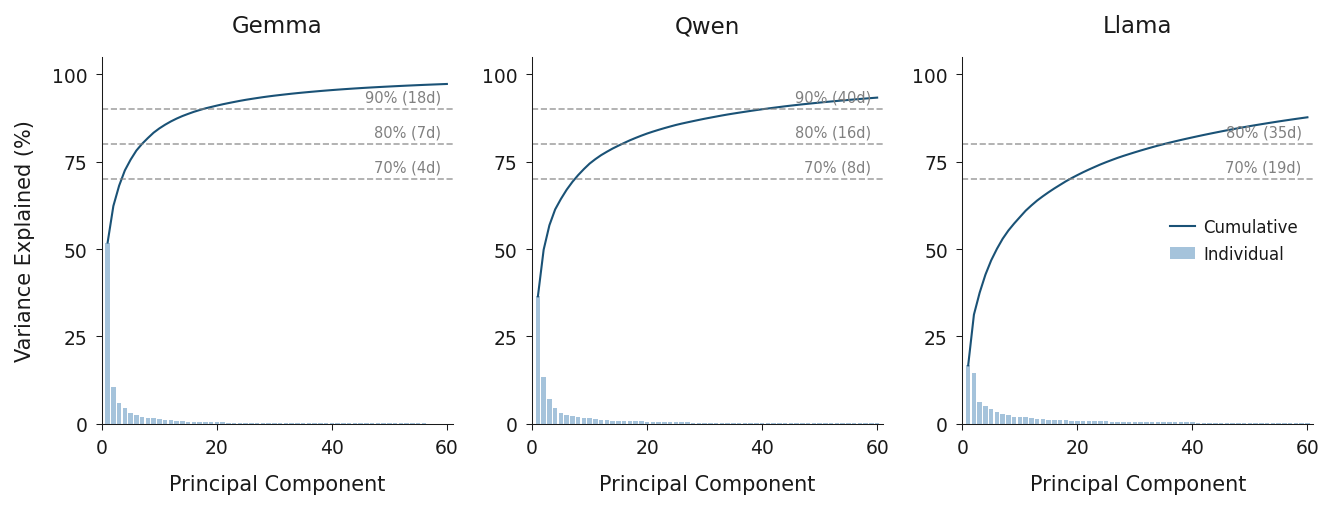

In [11]:
# Create figure with 3 side-by-side square plots for Role Space
fig, axes = plt.subplots(1, 3, figsize=(9, 3.5))

for i, (model_short, config) in enumerate(MODELS.items()):
    plot_variance_subplot(
        axes[i], 
        role_variance[model_short], 
        config['display_name'],
        max_components=MAX_COMPONENTS,
        show_ylabel=(i == 0)
    )

# Add legend to the last subplot
axes[-1].legend(loc='center right', fontsize=8)

plt.tight_layout()
plt.savefig(f"{plot_output_dir}/appendix_role_variance.pdf", dpi=300, bbox_inches='tight')
plt.show()

## Variance explained by trait space

In [12]:
# Load trait PCA results for all 3 models
trait_variance = {}
for model_short, config in MODELS.items():
    layer = config['layer']
    pca_path = f"/workspace/{model_short}/traits_240/pca/layer{layer}_mean_pos-neg50.pt"
    pca_results = torch.load(pca_path, weights_only=False)
    trait_variance[model_short] = pca_results['variance_explained']
    print(f"{model_short}: {len(trait_variance[model_short])} components")

gemma-2-27b: 239 components
qwen-3-32b: 240 components
llama-3.3-70b: 240 components


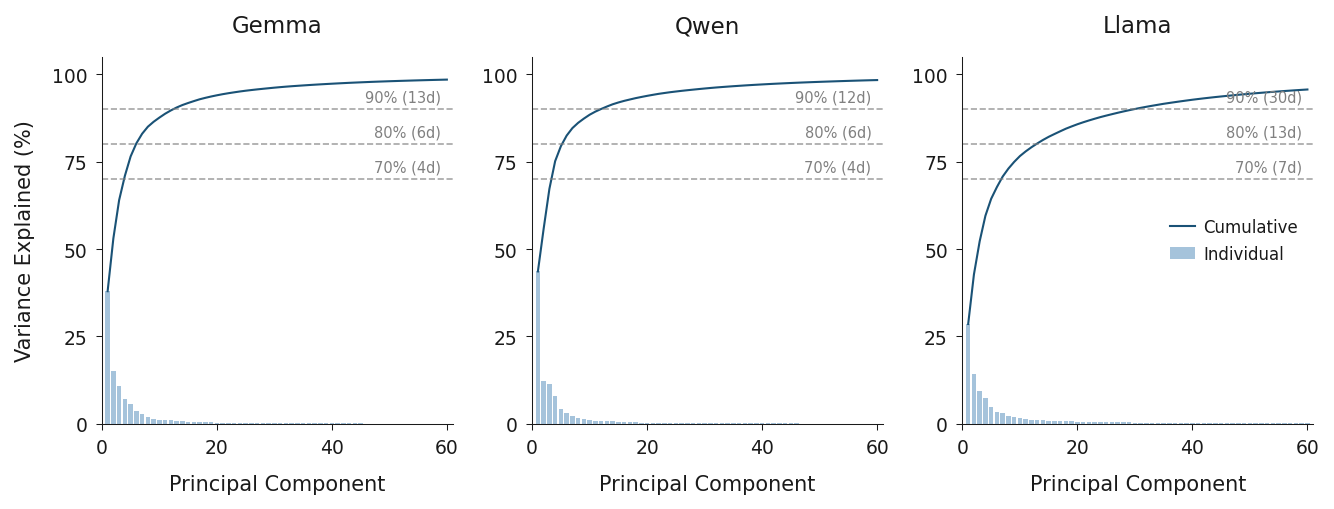

In [13]:
# Create figure with 3 side-by-side square plots for Trait Space
fig, axes = plt.subplots(1, 3, figsize=(9, 3.5))

for i, (model_short, config) in enumerate(MODELS.items()):
    plot_variance_subplot(
        axes[i], 
        trait_variance[model_short], 
        config['display_name'],
        max_components=MAX_COMPONENTS,
        show_ylabel=(i == 0)
    )

# Add legend to the last subplot
axes[-1].legend(loc='center right', fontsize=8)

plt.tight_layout()
plt.savefig(f"{plot_output_dir}/appendix_trait_variance.pdf", dpi=300, bbox_inches='tight')
plt.show()